---
title: Reproducing Chen et. al. (2021)'s unsupervised machine learning
subtitle: Using UMAP to reduce dimensions and HDBSCAN to cluster datapoints
author: Murthadza Aznam
date: '2022-10-20'
---

:::{.callout-note}

 📌 Goal: This notebook tries to reproduce the results from [https://ui.adsabs.harvard.edu/abs/2022MNRAS.509.1227C/abstract](https://ui.adsabs.harvard.edu/abs/2022MNRAS.509.1227C/abstract). As stated in the paper, verbatim 
 
 > Our goal is to **map several observational and model-dependent parameters of each FRB to a 2D embedding plane** by training the UMAP algorithm on the features of the training samples in CHIME/FRB dataset **and finally identify possibly misclassified non-repeating FRBs** which in fact have latent features of repeating FRBs. We define these possibly misclassified non-repeating FRBs as FRB repeater candidates in our paper.

:::

In [1]:
import umap
import pandas as pd
import seaborn as sns

from astropy.time import Time
from sklearn.model_selection import train_test_split

## 0. Getting the Data

### 0.1 Source
The paper uses data from CHIME/FRB Catalog with parameters calculated in [Hashimoto et. al. 2022](https://doi.org/10.1093/mnras/stac065).

In [2]:
catalog: pd.DataFrame = pd.read_csv('../data/raw/external/Hashimoto2022_chimefrbcat1.csv')
catalog

,tns_name,previous_name,repeater_name,ra,ra_err,ra_notes,dec,dec_err,dec_notes,gl,...,weight_fluence_error_m,weight,weight_error_p,weight_error_m,weighted_logrhoA,weighted_logrhoA_error_p,weighted_logrhoA_error_m,weighted_logrhoB,weighted_logrhoB_error_p,weighted_logrhoB_error_m
0,FRB20180725A,180725.J0613+67,-9999,93.42,0.04,-9999,67.10,0.20,-9999,147.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FRB20180727A,180727.J1311+26,-9999,197.70,0.10,-9999,26.40,0.30,-9999,24.76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FRB20180729A,180729.J1316+55,-9999,199.40,0.10,-9999,55.58,0.08,-9999,115.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FRB20180729B,180729.J0558+56,-9999,89.90,0.30,-9999,56.50,0.20,-9999,156.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FRB20180730A,180730.J0353+87,-9999,57.39,0.03,-9999,87.20,0.20,-9999,125.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,FRB20190701A,-9999,-9999,277.50,0.20,-9999,59.00,0.20,-9999,88.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
595,FRB20190701B,-9999,-9999,302.90,0.20,-9999,80.20,0.20,-9999,112.88,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
596,FRB20190701C,-9999,-9999,96.40,0.20,-9999,81.60,0.30,-9999,132.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
597,FRB20190701D,-9999,-9999,112.10,0.20,-9999,66.70,0.20,-9999,149.28,...,0.000649,1.361506,0.574701,0.206776,0.813142,0.485293,0.109293,0.894742,0.25519,0.19035


### 0.2 Dataset Validation

We first validate that the data is as described in the paper. According to the paper:

1. > The initial dataset includes 501 non-repeating FRB sub-bursts from 474 sources and 93 repeating FRB sub-bursts from 18 sources.
2. > The catalogue includes 535 FRBs at a frequency range between 400 and 800 MHz from **2018 July 25** to **2019 July 1**. Since a repeating FRB source provides several FRBs and each FRB might include several sub-bursts, the actual number of applying subburst samples are 501 non-repeating + 93 repeating = 594 sub-bursts.

We can verify this using a simple dataframe method.

In [3]:
start: float = Time('2018-07-25').mjd
end: float = Time('2019-07-01').mjd

interval: pd.Series = (start <= catalog['mjd_400']) & (catalog['mjd_400'] <= end)
catalog: pd.DataFrame = catalog[interval]

repeating: pd.DataFrame = catalog[(catalog['repeater_name'] != "-9999")]
non_repeating: pd.DataFrame = catalog[(catalog['repeater_name'] == "-9999")]
print(f"Total repeaters\t\t: {len(repeating)}",f"Total non-repeaters\t: {len(non_repeating)}", sep="\n")
print(f"Total sub-bursts\t: {len(repeating) + len(non_repeating)}")

Total repeaters		: 93
Total non-repeaters	: 501
Total sub-bursts	: 594


:::{.callout-note} 

TODO
Apply filter to get the number of sources.
This filter only gets the number of sub bursts.

:::

:::{.callout-question}

What does the authors mean by "The catalogue includes 535 FRBs"?
I could not think of a filter that fits the description.

:::

## 1. Preprocessing

### 1.1 Sample dan Selection

These are the criteria:

1. Observed between 2018 July 25 to 2019 July 1. (Already filtered in [Validation](#02-dataset-validation))
2. We exclude the FRB sub-bursts which have neither `flux` nor `fluence` measurements.
3. The input data for unsupervised learning includes a total of 10 observational and 3 model-dependent parameters. (Described in [Parameters](#12-parameters))

### 1.2 Parameters

### 1.2.1 Observational Parameters
The parameters selected by the paper is as follows:
- Boxcar Width `bc_width`
- Width of Sub-Burst `width_fitb`
- Flux `flux`
- Fluence `fluence`
- Scattering Time `scat_time`
- Spectral Index `sp_idx`
- Spectral Running `sp_run`
- Highest Frequency `high_freq`
- Lowest Frequency `low_freq`
- Peak Frequency `peak_freq`

### 1.2.2 Model Dependent Parameters
- Redshift `z`
- Radio Energy `logE_rest_400`
- Rest-Frame Intrinsic Duration `logsubw_int_rest`

In [4]:
from typing import List

params : List[str] = [
    # Observational
    "bc_width",
    "width_fitb",
    "flux",
    "fluence",
    "scat_time",
    "sp_idx",
    "sp_run",
    "high_freq",
    "low_freq",
    "peak_freq",
    # Model dependent
    "z",
    "logE_rest_400",
    "logsubw_int_rest"
]

identifiers: List[str] = [
    "tns_name",
    "repeater_name"
]

dropna_subset = ['flux', 'fluence', 'logE_rest_400']

non_repeating = non_repeating[[*params, *identifiers]]
repeating = repeating[[*params, *identifiers]]

## 2. Dimension Reduction

### 2.1 Split test and training data

In [5]:
test, train = train_test_split(repeating, test_size=0.9)

In [6]:
# to be trained
selected = pd.concat([train, non_repeating]).dropna(subset=dropna_subset)

### 2.2 UMAP

Parameters:

1. `n_neighbors = 8` 
    - it controls how UMAP balances between the local structure and the global structure of the data manifolds
2. `n_components = 2`
    - the resulting dimensionality of the reduced dimension
3. `min_dist = 0.1`
    - to prevent the resulting low dimensional projections clumping together

In [7]:
model: umap.UMAP = umap.UMAP(n_neighbors=8, n_components=2, min_dist=0.1)
map = model.fit(selected[params])
test_map = map.transform(test[params])

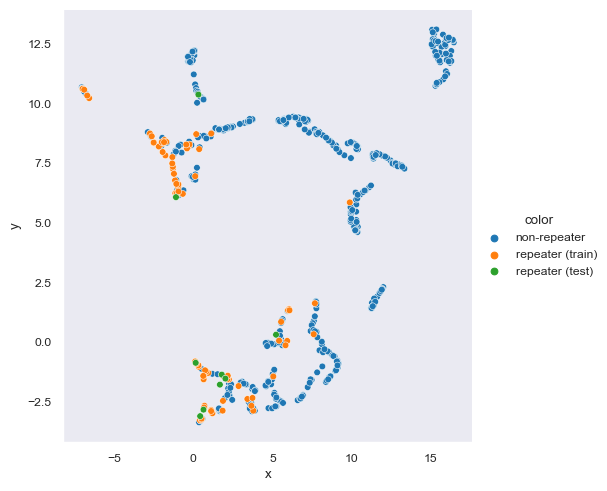

In [8]:
selected['x'] = map.embedding_[:, 0]
selected['y'] = map.embedding_[:, 1]
selected['color'] = ['non-repeater' if name == '-9999' else 'repeater (train)' for name in selected['repeater_name']]

selected = selected.sort_values(by=['color'])

test['x'] = test_map[:,0]
test['y'] = test_map[:,1]
test['color'] = 'repeater (test)'

to_plot = pd.concat([selected, test])

sns.set_style('dark')
sns.set_context('paper')
sns.relplot(data=to_plot, kind='scatter', x='x', y='y', hue='color', hue_order=['non-repeater','repeater (train)','repeater (test)'])

## 3. HDBSCAN

We now perform HDBSCAN to cluster data based on the dimensionally reduced data from UMAP.

### 3.1 Calculation

In [9]:
import hdbscan

The paper did not classify the minimum cluster size for HDBSCAN so I tried to find a parameter that fits.
The minimum cluster size (`clus_size`) that fits the paper's model is `19` as calculated by rounding `0.458 * to_plot.shape[1]`.

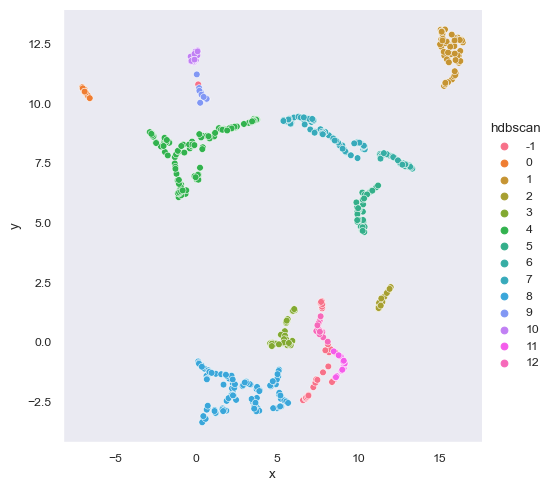

In [75]:
const = 0.485
clus_size = round(const * to_plot.shape[1])

model_ = hdbscan.HDBSCAN(clus_size)
to_plot['hdbscan'] = model_.fit_predict(to_plot[['x', 'y']])
to_plot = to_plot.sort_values(by='hdbscan', ascending=True)
to_plot['hdbscan'] = to_plot['hdbscan'].astype(str)
sns.relplot(data=to_plot, kind='scatter', x='x', y='y', hue='hdbscan')

### 3.2 Comparison

In this section we present the data from [Chen et al (2021)](https://ui.adsabs.harvard.edu/abs/2022MNRAS.509.1227C/abstract).

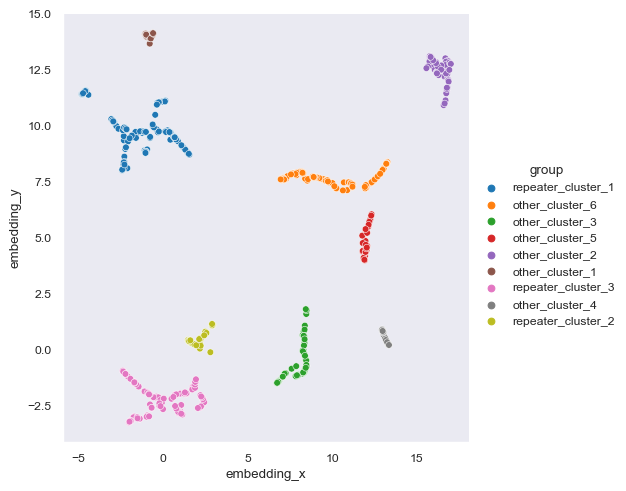

In [84]:
chen2021 = pd.read_csv('../data/raw/external/chen2021_classification.csv')
chen2021['source'] = 'chen et al 2021'
sns.relplot(data=chen2021, kind='scatter', x='embedding_x', y='embedding_y', hue='group')

As you can see, Chen et al (2021) contains 9 clusters while the one we did have 12 clusters.
The number of clusters itself is irrelevant but the size of clusters is.
What we want to know is whether or not we can replicate the classification of repeater clusters from non-repeater clusters.

A cluster is considered repeater cluster is the total number of more than 10% repeating FRB exists in the cluster.
Other FRBs inside the repeater cluster is determined to be 'potentially' repeating.
Then, we compare the division between this notebook and Chen et al (2021).

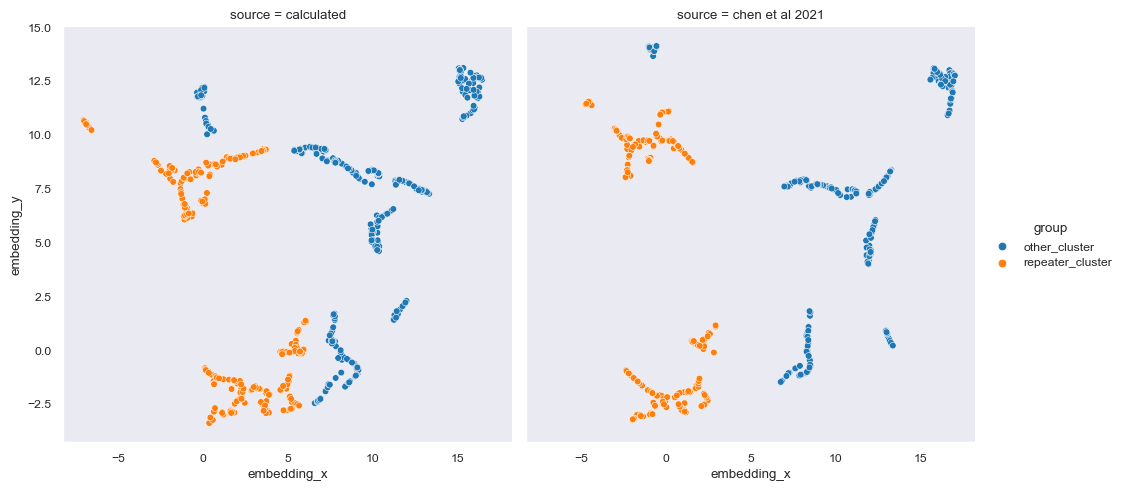

In [85]:
# Determining repeater clusters (>10% is repeater FRB)
this = to_plot[['tns_name','x','y', 'hdbscan', 'color']].rename(columns={'x': 'embedding_x', 'y':'embedding_y', 'hdbscan': 'label', 'color': 'repeater'})
this['source'] = 'calculated'
this['repeater'] = [False if name == 'non-repeater' else True for name in this['repeater']]
a = this.groupby('label').aggregate('mean', numeric_only=True)
a['group'] = ['repeater_cluster' if row > 0.1 else 'other_cluster' for row in a['repeater']]
a.reset_index()
this = this.merge(a[['group']], on='label')

# Rename groups to only separate repeater clusters from other clusters
chen2021['group'] = chen2021['group'].apply(lambda x: x[:-2])

data: pd.DataFrame = pd.concat([this, chen2021])
sns.relplot(data=data, kind='scatter', x='embedding_x', y='embedding_y', hue='group', col='source')

The division fairly replicates the one from Chen et al. (2021). 
However, some of the top left corner of the embedding is not classified as repeater in this notebook while it is in Chen et al. (2021).
We can continue analysis with more graphs from Chen et al. (2021).